<a href="https://colab.research.google.com/github/arshmehar/ssh_Indian_Ocean/blob/main/ssh_forecast_ssp585.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 76.0 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os

# regridding, gapfilling ssp585 according to timeseries dataset:

In [ ]:
ssp585=xr.open_dataset("/content/drive/MyDrive/prerna_data/Hadgem_ssp585_dsl_1979-2100.nc",decode_times=False)

In [ ]:
timeseries_dataset= xr.open_dataset("/content/drive/MyDrive/prerna_data/hadgem_aviso.nc", decode_times=False)


In [ ]:
print(timeseries_dataset)

<xarray.Dataset> Size: 9GB
Dimensions:            (ensemble_member: 47, TIME: 264, LATITUDE241_480: 240,
                        LONGITUDE841_1200: 360)
Coordinates:
  * TIME               (TIME) float64 2kB 5.15e+04 5.152e+04 ... 5.938e+04
  * LATITUDE241_480    (LATITUDE241_480) float32 960B -29.88 -29.62 ... 29.88
  * LONGITUDE841_1200  (LONGITUDE841_1200) float32 1kB 30.12 30.38 ... 119.9
Dimensions without coordinates: ensemble_member
Data variables:
    DSL                (ensemble_member, TIME, LATITUDE241_480, LONGITUDE841_1200) float64 9GB ...
    avisodsl           (TIME, LATITUDE241_480, LONGITUDE841_1200) float64 182MB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 08 10:59:39 2024: cdo selyear,1993/2014 dsl_7.nc LL...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


In [ ]:
print(ssp585)


<xarray.Dataset> Size: 1GB
Dimensions:  (LON: 360, LAT: 330, TIME: 1464)
Coordinates:
  * LON      (LON) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * LAT      (LAT) float64 3kB -89.73 -89.18 -88.64 -88.09 ... 88.64 89.18 89.73
  * TIME     (TIME) float64 12kB 4.646e+04 4.648e+04 ... 9.032e+04 9.034e+04
Data variables:
    DSL      (TIME, LAT, LON) float64 1GB ...
Attributes:
    history:      FERRET V7.3 (optimized)  8-Jul-25
    Conventions:  CF-1.6


In [ ]:
lat_res = ssp585['LAT'].diff(dim='LAT').mean().item()
lon_res = ssp585['LON'].diff(dim='LON').mean().item()
print(f"Latitude resolution: {lat_res} degrees")
print(f"Longitude resolution: {lon_res} degrees")


Latitude resolution: 0.5454545454545454 degrees
Longitude resolution: 1.0 degrees


In [ ]:
ssp585.DSL.isel(TIME=0).values.shape

(330, 360)

##regridding

In [ ]:
# lat_target = np.arange(-29.875, 30.0, 0.25)     # 240 points
# lon_target = np.arange(30.125, 120.0, 0.25)     #360

In [ ]:
# target_lon_grid, target_lat_grid = np.meshgrid(lon_target, lat_target)

In [ ]:
# source_lats = ssp585["LAT"].values
# source_lons = ssp585["LON"].values
# source_lon_grid, source_lat_grid = np.meshgrid(source_lons, source_lats)

# # Flatten source coordinates
# source_points = np.column_stack((source_lon_grid.ravel(), source_lat_grid.ravel()))


In [ ]:
# from tqdm import tqdm

# regridded_data = []

# for t in tqdm(range(ssp_dsl.shape[0]), desc="Regridding"):
#     dsl_snapshot = ssp_dsl.isel(TIME=t).values  # shape: (LAT, LON)

#     # Flatten DSL data
#     values = dsl_snapshot.ravel()

#     # Interpolate to target grid
#     interpolated = griddata(
#         points=source_points,
#         values=values,
#         xi=(target_lon_grid, target_lat_grid),
#         method='linear'
#     )

#     regridded_data.append(interpolated)

# regridded_data = np.array(regridded_data)  # shape: (TIME, 240, 360)


In [ ]:
# regridded_ds = xr.Dataset(
#     {
#         "DSL": (["TIME", "LAT", "LON"], regridded_data)
#     },
#     coords={
#         "TIME": ssp585["TIME"],
#         "LAT": lat_target,
#         "LON": lon_target
#     }
# )

# regridded_ds.to_netcdf("/content/drive/MyDrive/prerna_data/ssp585_regridded.nc")


##masking, gap filling

In [ ]:
ssp_regridded= xr.open_dataset("/content/drive/MyDrive/prerna_data/ssp585_regridded.nc", decode_times=False)

In [ ]:
print(ssp_regridded)

<xarray.Dataset> Size: 1GB
Dimensions:  (TIME: 1464, LAT: 240, LON: 360)
Coordinates:
  * TIME     (TIME) float64 12kB 4.646e+04 4.648e+04 ... 9.032e+04 9.034e+04
  * LON      (LON) float64 3kB 30.12 30.38 30.62 30.88 ... 119.4 119.6 119.9
  * LAT      (LAT) float64 2kB -29.88 -29.62 -29.38 -29.12 ... 29.38 29.62 29.88
Data variables:
    DSL      (TIME, LAT, LON) float64 1GB ...


In [ ]:
lat_res = ssp_regridded['LAT'].diff(dim='LAT').mean().item()
lon_res = ssp_regridded['LON'].diff(dim='LON').mean().item()
print(f"Latitude resolution: {lat_res} degrees")
print(f"Longitude resolution: {lon_res} degrees")

Latitude resolution: 0.25 degrees
Longitude resolution: 0.25 degrees


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


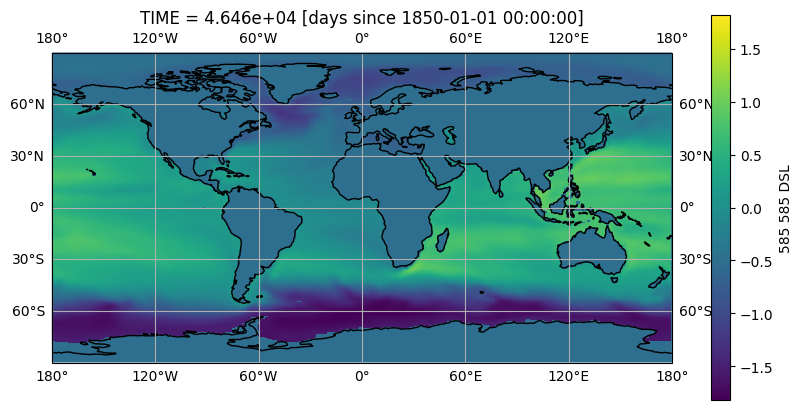

In [ ]:
data_var = ssp585['DSL']
data = data_var.isel(TIME=0)  # Select first time step

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
data.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), cbar_kwargs={'label': '585 585 DSL'})
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()


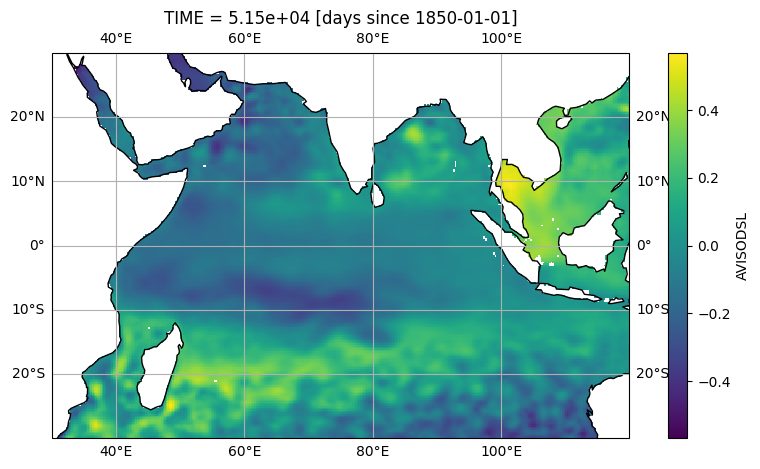

In [ ]:
data_var = timeseries_dataset['avisodsl']

data = data_var.isel(TIME=0)  # Select first time step

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
data.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'AVISODSL'})
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()


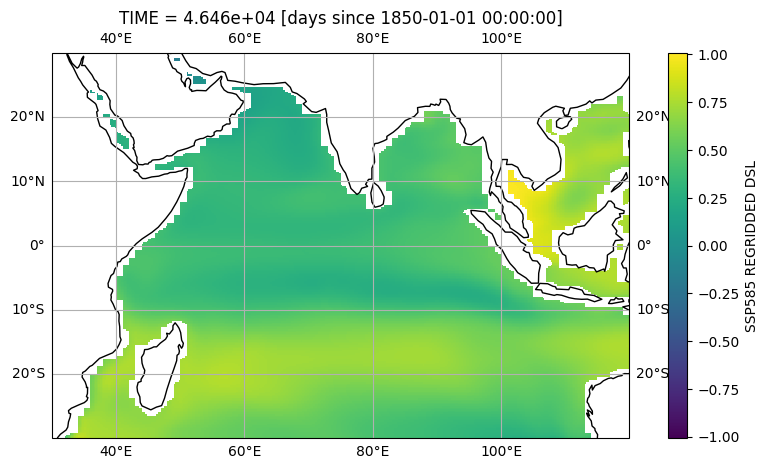

In [ ]:
data_var = ssp_regridded['DSL']
data = data_var.isel(TIME=0)  # Select first time step

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
data.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'SSP585 REGRIDDED DSL'})
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()


In [ ]:
# Inspect dataset
print(ssp_regridded)
print(ssp_regridded['DSL'].isnull().sum())

<xarray.Dataset> Size: 1GB
Dimensions:  (TIME: 1464, LAT: 240, LON: 360)
Coordinates:
  * TIME     (TIME) float64 12kB 4.646e+04 4.648e+04 ... 9.032e+04 9.034e+04
  * LON      (LON) float64 3kB 30.12 30.38 30.62 30.88 ... 119.4 119.6 119.9
  * LAT      (LAT) float64 2kB -29.88 -29.62 -29.38 -29.12 ... 29.38 29.62 29.88
Data variables:
    DSL      (TIME, LAT, LON) float64 1GB ...
<xarray.DataArray 'DSL' ()> Size: 8B
array(51606000)


In [ ]:
# def fill_nan_interpolation(data, lons, lats):
#     # Flatten the arrays for interpolation
#     lons_flat, lats_flat = np.meshgrid(lons, lats)
#     lons_flat = lons_flat.flatten()
#     lats_flat = lats_flat.flatten()
#     data_flat = data.flatten()

#     # Create mask for NaNs
#     mask = ~np.isnan(data_flat)

#     # Extract non-NaN values and their coordinates
#     data_masked = data_flat[mask]
#     lons_masked = lons_flat[mask]
#     lats_masked = lats_flat[mask]

#     # Perform nearest-neighbor interpolation
#     interp = scipy.interpolate.NearestNDInterpolator(
#         (lons_masked, lats_masked), data_masked
#     )

#     # Interpolate NaN locations
#     filled_data = interp(lons_flat, lats_flat).reshape(data.shape)

#     return filled_data


In [ ]:
# filled_ds = ssp_regridded.copy(deep=True)



# for t in range(ssp_regridded.sizes['TIME']):
#     # Extract the current data slice
#     original_vals = ssp_regridded['DSL'].isel(TIME=t).values
#     original_lons = ssp_regridded['LON'].values
#     original_lats = ssp_regridded['LAT'].values

#     # Fill NaNs
#     filled_vals = fill_nan_interpolation(original_vals, original_lons, original_lats)

#     # Update the dataset with filled values
#     filled_ds['DSL'].isel(TIME=t).values[:] = filled_vals

In [ ]:
# print(filled_ds)
# print(filled_ds['DSL'].isnull().sum())

In [ ]:

# dsl_across_members = filled_ds['DSL']
# first_month = dsl_across_members.isel(TIME=0)
# plt.figure(figsize=(12, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# first_month.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
#                             cbar_kwargs={'label': 'DSL (meters)'})
# ax.coastlines()
# ax.gridlines(draw_labels=True)
# plt.title("First Month of Dynamic Sea Levels (DSL)")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()


In [ ]:
# print("NaNs in combined_ds['DSL']:", ssp_regridded['DSL'].isnull().sum())
# print("NaNs in filled_ds['DSL']:", filled_ds['DSL'].isnull().sum())

In [ ]:
# # Interpolation step
# interp_ds = filled_ds.interp(
#     LAT=("LAT", lat_target),
#     LON=("LON", lon_target),
#     method='linear'
# )

# # Save the interpolated dataset
# output_path = "interpolated_ssp585.nc"
# interp_ds.to_netcdf(output_path)

# print(" Interpolation complete. File saved to:", output_path)

In [ ]:
# dsl_across_members = interp_ds['DSL']
# first_month = dsl_across_members.isel(TIME=0)
# plt.figure(figsize=(12, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# first_month.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
#                             cbar_kwargs={'label': 'DSL (meters)'})
# ax.coastlines()
# ax.gridlines(draw_labels=True)
# plt.title("First Month of Dynamic Sea Levels (DSL)")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()


In [ ]:
# mask = timeseries_dataset['avisodsl'].isel(TIME=0).values
# mask = mask/mask
# mask

In [ ]:
# interp_ds

In [ ]:
# timeseries_dataset['avisodsl']

In [ ]:
# #  Convert mask to DataArray
# avisodsl_mask = xr.DataArray(
#     mask,  # Convert bool to float (1.0 or 0.0)
#     coords={'LAT': interp_ds.LAT, 'LON': interp_ds.LON},
#     dims=['LAT', 'LON']
# )

# # Broadcast the 2D mask to 3D
# n_time = interp_ds.sizes['TIME']
# mask_broadcasted = avisodsl_mask.expand_dims(TIME=n_time).transpose('TIME', 'LAT', 'LON')

# #Apply the mask
# interp_ds['DSL'] = interp_ds['DSL'] * mask_broadcasted


In [ ]:
# dsl_across_members = interp_ds['DSL']
# first_month = dsl_across_members.isel(TIME=1000)
# plt.figure(figsize=(12, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# first_month.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
#                             cbar_kwargs={'label': 'DSL (meters)'})
# ax.coastlines()
# ax.gridlines(draw_labels=True)
# plt.title("First Month of Dynamic Sea Levels (DSL)")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

In [ ]:
# interp_ds.to_netcdf('/content/drive/MyDrive/prerna_data/ssp585_predictions/ssp585_corrected.nc')

In [ ]:
#

In [ ]:
#

#Patch Architecture

In [ ]:
__all__ = ['Transpose', 'get_activation_fn', 'moving_avg', 'series_decomp', 'PositionalEncoding', 'SinCosPosEncoding', 'Coord2dPosEncoding', 'Coord1dPosEncoding', 'positional_encoding']

import torch
from torch import nn
import math

class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False):
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)


def get_activation_fn(activation):
    if callable(activation): return activation()
    elif activation.lower() == "relu": return nn.ReLU()
    elif activation.lower() == "gelu": return nn.GELU()
    raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable')


# decomposition

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean



# pos_encoding

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe

SinCosPosEncoding = PositionalEncoding

def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3, verbose=False):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        pv(f'{i:4.0f}  {x:5.3f}  {cpe.mean():+6.3f}', verbose)
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def Coord1dPosEncoding(q_len, exponential=False, normalize=True):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def positional_encoding(pe, learn_pe, q_len, d_model):
    # Positional encoding
    if pe == None:
        W_pos = torch.empty((q_len, d_model)) # pe = None and learn_pe = False can be used to measure impact of pe
        nn.init.uniform_(W_pos, -0.02, 0.02)
        learn_pe = False
    elif pe == 'zero':
        W_pos = torch.empty((q_len, 1))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'zeros':
        W_pos = torch.empty((q_len, d_model))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'normal' or pe == 'gauss':
        W_pos = torch.zeros((q_len, 1))
        torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
    elif pe == 'uniform':
        W_pos = torch.zeros((q_len, 1))
        nn.init.uniform_(W_pos, a=0.0, b=0.1)
    elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
    elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
    elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True)
    elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=True)
    elif pe == 'sincos': W_pos = PositionalEncoding(q_len, d_model, normalize=True)
    else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
        'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
    return nn.Parameter(W_pos, requires_grad=learn_pe)

In [ ]:
# code from https://github.com/ts-kim/RevIN, with minor modifications

import torch
import torch.nn as nn

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

In [ ]:
__all__ = ['PatchTST_backbone']

# Cell
from typing import Callable, Optional
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as F
import numpy as np

#from collections import OrderedDict
# from layers.PatchTST_layers import *
# from layers.RevIN import RevIN

# Cell
class PatchTST_backbone(nn.Module):
    def __init__(self, c_in:int, context_window:int, target_window:int, patch_len:int, stride:int, max_seq_len:Optional[int]=1024,
                 n_layers:int=3, d_model=128, n_heads=16, d_k:Optional[int]=None, d_v:Optional[int]=None,
                 d_ff:int=256, norm:str='BatchNorm', attn_dropout:float=0., dropout:float=0., act:str="gelu", key_padding_mask:bool='auto',
                 padding_var:Optional[int]=None, attn_mask:Optional[Tensor]=None, res_attention:bool=True, pre_norm:bool=False, store_attn:bool=False,
                 pe:str='zeros', learn_pe:bool=True, fc_dropout:float=0., head_dropout = 0, padding_patch = None,
                 pretrain_head:bool=False, head_type = 'flatten', individual = False, revin = True, affine = True, subtract_last = False,
                 verbose:bool=False, **kwargs):

        super().__init__()

        # RevIn
        self.revin = revin
        if self.revin: self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)

        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        patch_num = int((context_window - patch_len)/stride + 1)
        if padding_patch == 'end': # can be modified to general case
            self.padding_patch_layer = nn.ReplicationPad1d((0, stride))
            patch_num += 1

        # Backbone
        self.backbone = TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff,
                                attn_dropout=attn_dropout, dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                pe=pe, learn_pe=learn_pe, verbose=verbose, **kwargs)

        # Head
        self.head_nf = d_model * patch_num
        self.n_vars = c_in
        self.pretrain_head = pretrain_head
        self.head_type = head_type
        self.individual = individual

        if self.pretrain_head:
            self.head = self.create_pretrain_head(self.head_nf, c_in, fc_dropout) # custom head passed as a partial func with all its kwargs
        elif head_type == 'flatten':
            self.head = Flatten_Head(self.individual, self.n_vars, self.head_nf, target_window, head_dropout=head_dropout)


    def forward(self, z):                                                                   # z: [bs x nvars x seq_len]
        # norm
        if self.revin:
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'norm')
            z = z.permute(0,2,1)

        # do patching
        if self.padding_patch == 'end':
            z = self.padding_patch_layer(z)
        z = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)                   # z: [bs x nvars x patch_num x patch_len]
        z = z.permute(0,1,3,2)                                                              # z: [bs x nvars x patch_len x patch_num]

        # model
        z = self.backbone(z)                                                                # z: [bs x nvars x d_model x patch_num]
        z = self.head(z)                                                                    # z: [bs x nvars x target_window]

        # denorm
        if self.revin:
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'denorm')
            z = z.permute(0,2,1)
        return z

    def create_pretrain_head(self, head_nf, vars, dropout):
        return nn.Sequential(nn.Dropout(dropout),
                    nn.Conv1d(head_nf, vars, 1)
                    )


class Flatten_Head(nn.Module):
    def __init__(self, individual, n_vars, nf, target_window, head_dropout=0):
        super().__init__()

        self.individual = individual
        self.n_vars = n_vars

        if self.individual:
            self.linears = nn.ModuleList()
            self.dropouts = nn.ModuleList()
            self.flattens = nn.ModuleList()
            for i in range(self.n_vars):
                self.flattens.append(nn.Flatten(start_dim=-2))
                self.linears.append(nn.Linear(nf, target_window))
                self.dropouts.append(nn.Dropout(head_dropout))
        else:
            self.flatten = nn.Flatten(start_dim=-2)
            self.linear = nn.Linear(nf, target_window)
            self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):                                 # x: [bs x nvars x d_model x patch_num]
        if self.individual:
            x_out = []
            for i in range(self.n_vars):
                z = self.flattens[i](x[:,i,:,:])          # z: [bs x d_model * patch_num]
                z = self.linears[i](z)                    # z: [bs x target_window]
                z = self.dropouts[i](z)
                x_out.append(z)
            x = torch.stack(x_out, dim=1)                 # x: [bs x nvars x target_window]
        else:
            x = self.flatten(x)
            x = self.linear(x)
            x = self.dropout(x)
        return x




class TSTiEncoder(nn.Module):  #i means channel-independent
    def __init__(self, c_in, patch_num, patch_len, max_seq_len=1024,
                 n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., act="gelu", store_attn=False,
                 key_padding_mask='auto', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 pe='zeros', learn_pe=True, verbose=False, **kwargs):


        super().__init__()

        self.patch_num = patch_num
        self.patch_len = patch_len

        # Input encoding
        q_len = patch_num
        self.W_P = nn.Linear(patch_len, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len

        # Positional encoding
        self.W_pos = positional_encoding(pe, learn_pe, q_len, d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.encoder = TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout, dropout=dropout,
                                   pre_norm=pre_norm, activation=act, res_attention=res_attention, n_layers=n_layers, store_attn=store_attn)


    def forward(self, x) -> Tensor:                                              # x: [bs x nvars x patch_len x patch_num]

        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)                                                          # x: [bs x nvars x patch_num x d_model]

        u = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))      # u: [bs * nvars x patch_num x d_model]
        u = self.dropout(u + self.W_pos)                                         # u: [bs * nvars x patch_num x d_model]

        # Encoder
        z = self.encoder(u)                                                      # z: [bs * nvars x patch_num x d_model]
        z = torch.reshape(z, (-1,n_vars,z.shape[-2],z.shape[-1]))                # z: [bs x nvars x patch_num x d_model]
        z = z.permute(0,1,3,2)                                                   # z: [bs x nvars x d_model x patch_num]

        return z



# Cell
class TSTEncoder(nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=None,
                        norm='BatchNorm', attn_dropout=0., dropout=0., activation='gelu',
                        res_attention=False, n_layers=1, pre_norm=False, store_attn=False):
        super().__init__()

        self.layers = nn.ModuleList([TSTEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm,
                                                      attn_dropout=attn_dropout, dropout=dropout,
                                                      activation=activation, res_attention=res_attention,
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src:Tensor, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers: output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers: output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output



class TSTEncoderLayer(nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=256, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, activation="gelu", res_attention=False, pre_norm=False):
        super().__init__()
        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(d_model, n_heads, d_k, d_v, attn_dropout=attn_dropout, proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_attn = nn.LayerNorm(d_model)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff, bias=bias),
                                get_activation_fn(activation),
                                nn.Dropout(dropout),
                                nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_ffn = nn.LayerNorm(d_model)

        self.pre_norm = pre_norm
        self.store_attn = store_attn


    def forward(self, src:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None) -> Tensor:

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src




class _MultiheadAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_k=None, d_v=None, res_attention=False, attn_dropout=0., proj_dropout=0., qkv_bias=True, lsa=False):
        """Multi Head Attention Layer
        Input shape:
            Q:       [batch_size (bs) x max_q_len x d_model]
            K, V:    [batch_size (bs) x q_len x d_model]
            mask:    [q_len x q_len]
        """
        super().__init__()
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(d_model, n_heads, attn_dropout=attn_dropout, res_attention=self.res_attention, lsa=lsa)

        # Poject output
        self.to_out = nn.Sequential(nn.Linear(n_heads * d_v, d_model), nn.Dropout(proj_dropout))


    def forward(self, Q:Tensor, K:Optional[Tensor]=None, V:Optional[Tensor]=None, prev:Optional[Tensor]=None,
                key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):

        bs = Q.size(0)
        if K is None: K = Q
        if V is None: V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s, prev=prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            output, attn_weights = self.sdp_attn(q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights


class _ScaledDotProductAttention(nn.Module):
    r"""Scaled Dot-Product Attention module (Attention is all you need by Vaswani et al., 2017) with optional residual attention from previous layer
    (Realformer: Transformer likes residual attention by He et al, 2020) and locality self sttention (Vision Transformer for Small-Size Datasets
    by Lee et al, 2021)"""

    def __init__(self, d_model, n_heads, attn_dropout=0., res_attention=False, lsa=False):
        super().__init__()
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = d_model // n_heads
        self.scale = nn.Parameter(torch.tensor(head_dim ** -0.5), requires_grad=lsa)
        self.lsa = lsa

    def forward(self, q:Tensor, k:Tensor, v:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):
        '''
        Input shape:
            q               : [bs x n_heads x max_q_len x d_k]
            k               : [bs x n_heads x d_k x seq_len]
            v               : [bs x n_heads x seq_len x d_v]
            prev            : [bs x n_heads x q_len x seq_len]
            key_padding_mask: [bs x seq_len]
            attn_mask       : [1 x seq_len x seq_len]
        Output shape:
            output:  [bs x n_heads x q_len x d_v]
            attn   : [bs x n_heads x q_len x seq_len]
            scores : [bs x n_heads x q_len x seq_len]
        '''

        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        attn_scores = torch.matmul(q, k) * self.scale      # attn_scores : [bs x n_heads x max_q_len x q_len]

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None: attn_scores = attn_scores + prev

        # Attention mask (optional)
        if attn_mask is not None:                                     # attn_mask with shape [q_len x seq_len] - only used when q_len == seq_len
            if attn_mask.dtype == torch.bool:
                attn_scores.masked_fill_(attn_mask, -np.inf)
            else:
                attn_scores += attn_mask

        # Key padding mask (optional)
        if key_padding_mask is not None:                              # mask with shape [bs x q_len] (only when max_w_len == q_len)
            attn_scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), -np.inf)

        # normalize the attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)                 # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(attn_weights, v)                        # output: [bs x n_heads x max_q_len x d_v]

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights

In [ ]:
class Configs:
    def __init__(self):
        self.enc_in = 1             # Number of features
        self.seq_len = 264           # Input sequence length
        self.pred_len = 264          # Target sequence length (same as input for many-to-many)
        self.e_layers = 2           # Number of transformer encoder layers
        self.n_heads = 4            # Number of attention heads
        self.d_model = 64           # Embedding dimension
        self.d_ff = 128             # Feedforward dimension
        self.dropout = 0.1
        self.fc_dropout = 0.1
        self.head_dropout = 0.1
        self.individual = False     # Shared head for all variables
        self.patch_len = 16         # Length of each patch
        self.stride = 8             # Stride for patching
        self.padding_patch = 'end'  # Padding option
        self.revin = True           # Whether to use RevIN
        self.affine = True
        self.subtract_last = False
        self.decomposition = False  # Whether to use decomposition module
        self.kernel_size = 25       # Only used if decomposition=True


In [ ]:
import torch

# Recreate the same model architecture
configs = Configs()
model = PatchTST_backbone(
    configs=configs,
    c_in=configs.enc_in,
    context_window=configs.seq_len,
    target_window=configs.pred_len,
    patch_len=configs.patch_len,
    stride=configs.stride
)

# Load the saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/prerna_data/best_patchtst_epoch_39_val_0.0002.pth"))

# Move to device (if needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()


PatchTST_backbone(
  (revin_layer): RevIN()
  (backbone): TSTiEncoder(
    (W_P): Linear(in_features=16, out_features=128, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (encoder): TSTEncoder(
      (layers): ModuleList(
        (0-2): 3 x TSTEncoderLayer(
          (self_attn): _MultiheadAttention(
            (W_Q): Linear(in_features=128, out_features=128, bias=True)
            (W_K): Linear(in_features=128, out_features=128, bias=True)
            (W_V): Linear(in_features=128, out_features=128, bias=True)
            (sdp_attn): _ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (dropout_attn): Dropout(p=0.0, inplace=False)
          (norm_attn): Sequential(
            (0): Transpose()
            (1): BatchNorm1d(128, eps=1e-05

#Forecast

In [ ]:
ssp_585 = xr.open_dataset('/content/drive/MyDrive/prerna_data/ssp585_predictions/ssp585_corrected.nc', decode_times=False)

In [ ]:
ssp_585

<xarray.Dataset> Size: 1GB
Dimensions:  (TIME: 1464, LAT: 240, LON: 360)
Coordinates:
  * TIME     (TIME) float64 12kB 4.646e+04 4.648e+04 ... 9.032e+04 9.034e+04
  * LON      (LON) float64 3kB 30.12 30.38 30.62 30.88 ... 119.4 119.6 119.9
  * LAT      (LAT) float64 2kB -29.88 -29.62 -29.38 -29.12 ... 29.38 29.62 29.88
Data variables:
    DSL      (TIME, LAT, LON) float64 1GB ...

In [ ]:
ssp_585.TIME.values

array([46455., 46485., 46515., ..., 90285., 90315., 90345.])

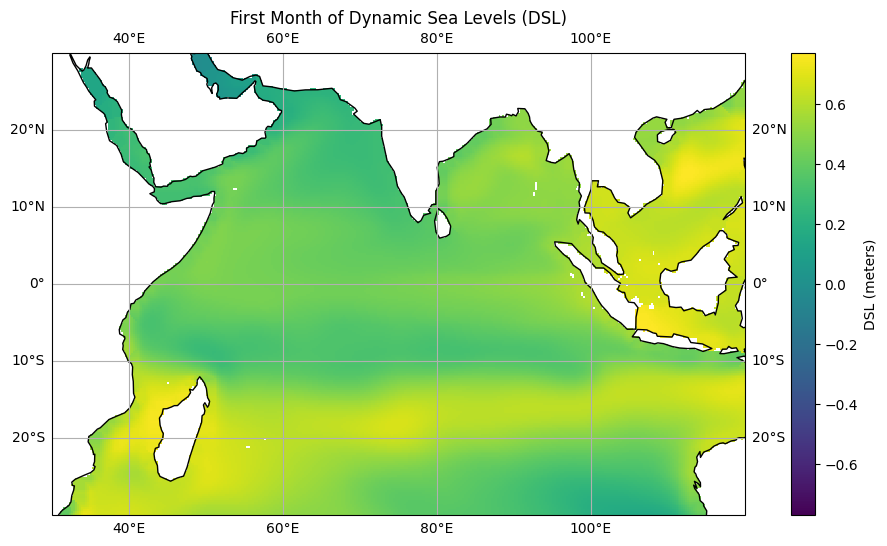

In [ ]:
dsl_across_members = ssp_585['DSL']
first_month = dsl_across_members.isel(TIME=1000)
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
first_month.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                            cbar_kwargs={'label': 'DSL (meters)'})
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("First Month of Dynamic Sea Levels (DSL)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

forecast: years 2025-2044

In [ ]:
# # Step 1: Prepare input from regridded & interpolated ssp_585 dataset
dsl = ssp_585['DSL'].values  # shape: (1464, 240, 360)
n_lat, n_lon = dsl.shape[1], dsl.shape[2]
n_grid = n_lat * n_lon

# Extract last 264 months (to match model's input context window)
x_input = dsl[-264:, :, :]  # shape: (264, 240, 360)
x_input = np.transpose(x_input, (1, 2, 0)).reshape(-1, 264)  # shape: (N, 264)
x_tensor = torch.from_numpy(x_input).float().unsqueeze(1).to(device)  # shape: (N, 1, 264)

# Step 2: Predict in batches to avoid OOM
batch_size = 512
y_pred = []

model.eval()
with torch.no_grad():
    for i in range(0, n_grid, batch_size):
        batch = x_tensor[i:i + batch_size]
        pred_batch = model(batch).squeeze(1).cpu().numpy()  # shape: (B, 264)
        y_pred.append(pred_batch)

y_pred = np.concatenate(y_pred, axis=0)  # shape: (N, 264)

# Step 3: Keep only the first 240 months (2025–2044), reshape to annual
y_pred_sliced = y_pred[:, :240]  # shape: (N, 240)
y_pred_annual = y_pred_sliced.reshape(n_grid, 20, 12).mean(axis=2)  # shape: (N, 20)
forecast_reshaped = y_pred_annual.reshape(n_lat, n_lon, 20).transpose(2, 0, 1)  # shape: (20, 240, 360)

# Step 4: Create annual time coordinate
forecast_years = np.arange(2025, 2045)  # 2025 to 2044

# Step 5: Create and save the forecast dataset
forecast_ds = xr.DataArray(
    forecast_reshaped,
    dims=['TIME', 'LAT', 'LON'],
    coords={
        'TIME': forecast_years,
        'LAT': ssp_585['LAT'],
        'LON': ssp_585['LON']
    },
    name='DSL_forecast'
).to_dataset(name='DSL_forecast')

In [ ]:
# forecast_ds.to_netcdf("/content/drive/MyDrive/prerna_data/ssp585_predictions/patchtst_ssp585_forecast_2025_2044.nc")
# print("Forecast saved to 'patchtst_decadal_forecast_2025_2044.nc'")

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the forecasted dataset
forecast_ds = xr.open_dataset("/content/drive/MyDrive/prerna_data/ssp585_predictions/patchtst_ssp585_forecast_2025_2044.nc")
dsl_pred = forecast_ds['DSL_forecast']  # shape: (TIME=20, LAT=240, LON=360)


In [ ]:
print(forecast_ds)

<xarray.Dataset> Size: 7MB
Dimensions:       (TIME: 20, LAT: 240, LON: 360)
Coordinates:
  * TIME          (TIME) int64 160B 2025 2026 2027 2028 ... 2041 2042 2043 2044
  * LAT           (LAT) float64 2kB -29.88 -29.62 -29.38 ... 29.38 29.62 29.88
  * LON           (LON) float64 3kB 30.12 30.38 30.62 ... 119.4 119.6 119.9
Data variables:
    DSL_forecast  (TIME, LAT, LON) float32 7MB nan nan nan nan ... nan nan nan


In [ ]:
print(dsl_pred)

<xarray.DataArray 'DSL_forecast' (TIME: 20, LAT: 240, LON: 360)> Size: 7MB
[1728000 values with dtype=float32]
Coordinates:
  * LON      (LON) float64 3kB 30.12 30.38 30.62 30.88 ... 119.4 119.6 119.9
  * LAT      (LAT) float64 2kB -29.88 -29.62 -29.38 -29.12 ... 29.38 29.62 29.88
  * TIME     (TIME) int32 80B 2025 2026 2027 2028 2029 ... 2041 2042 2043 2044


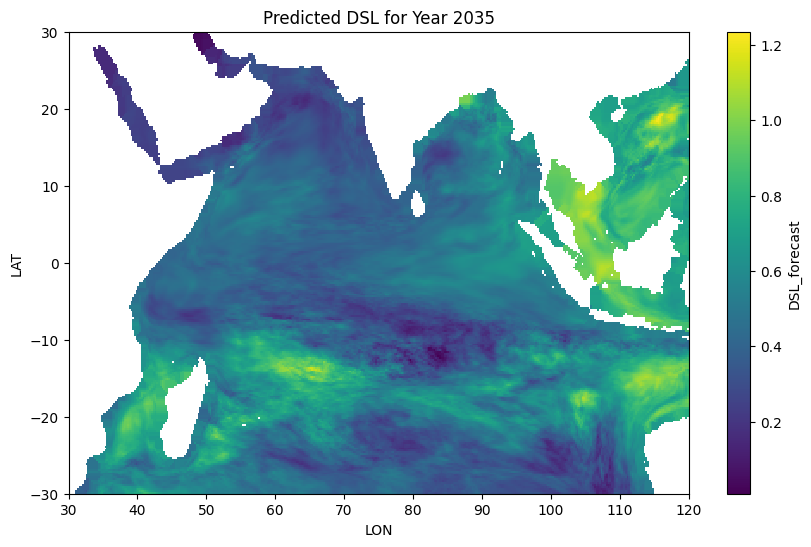

In [ ]:
year_index = 10  # for 2035 (indexing from 0 for 2025)
plt.figure(figsize=(10, 6))
dsl_pred.isel(TIME=year_index).plot(cmap='viridis')
plt.title(f"Predicted DSL for Year {int(dsl_pred.TIME[year_index].values)}")
plt.show()


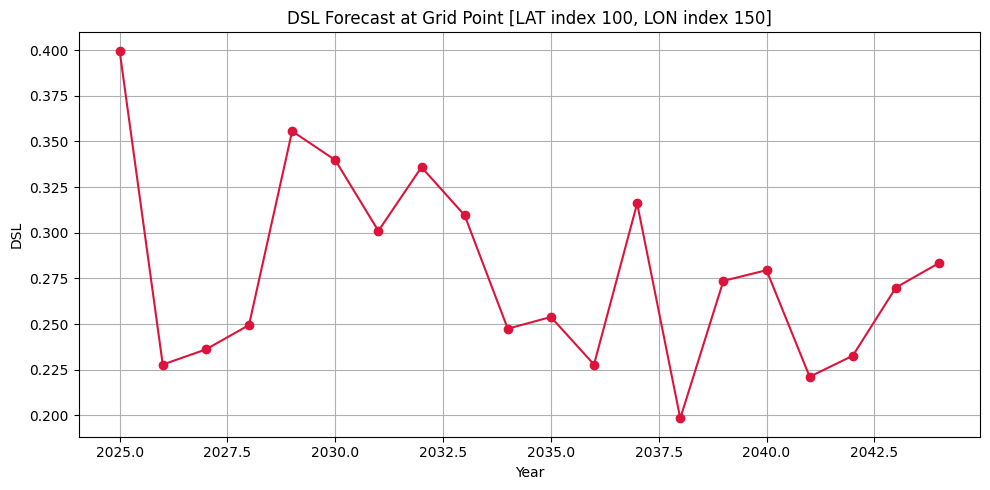

In [ ]:
import matplotlib.pyplot as plt

# Example: Choose a specific grid point (latitude & longitude index)
lat_index = 100
lon_index = 150

# Extract time series for the selected grid point
dsl_series = dsl_pred[:, lat_index, lon_index]  # shape: (20,)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(dsl_pred.TIME, dsl_series, marker='o', color='crimson')
plt.title(f"DSL Forecast at Grid Point [LAT index {lat_index}, LON index {lon_index}]")
plt.xlabel("Year")
plt.ylabel("DSL")
plt.grid(True)
plt.tight_layout()
plt.show()


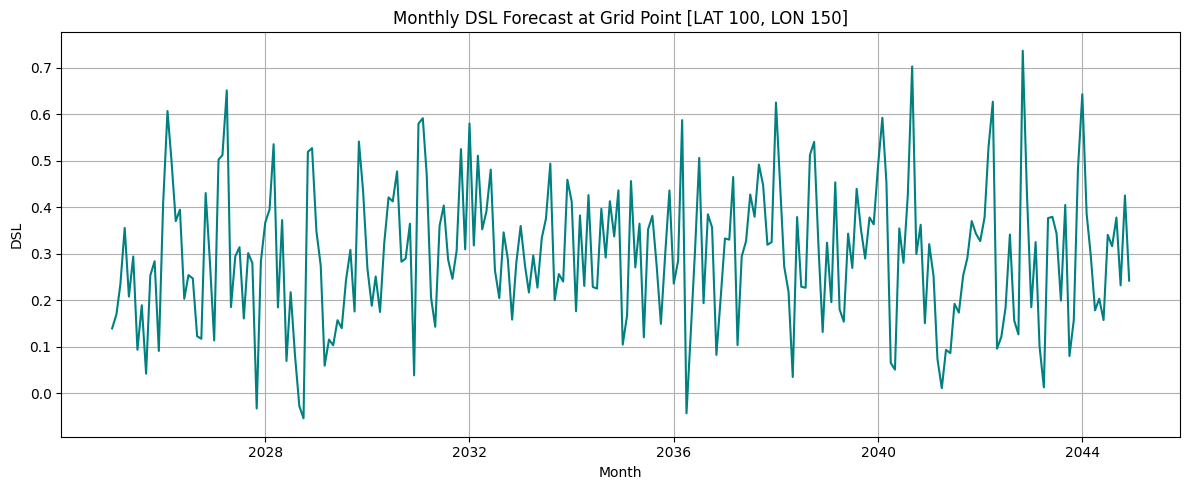

In [ ]:
import matplotlib.pyplot as plt

lat_index = 100
lon_index = 150
grid_index = lat_index * n_lon + lon_index  # flattening (row-major)

# Extract monthly series: shape (240,) — 240 months from 2025 to 2044
monthly_series = y_pred[grid_index, :240]

# Create monthly time axis
months = np.arange('2025-01', '2045-01', dtype='datetime64[M]')  # 240 months

# Plot
plt.figure(figsize=(12, 5))
plt.plot(months, monthly_series, color='teal')
plt.title(f"Monthly DSL Forecast at Grid Point [LAT {lat_index}, LON {lon_index}]")
plt.xlabel("Month")
plt.ylabel("DSL")
plt.grid(True)
plt.tight_layout()
plt.show()


forecast: years 2031-2050

In [ ]:
# Extract the last 264 months before 2031 (assumes monthly data starting from 1850)
# If 2031 corresponds to index 972 (81 years × 12), we extract months 708–971
x_input = dsl[708:972, :, :]  # shape: (264, 240, 360)
x_input = np.transpose(x_input, (1, 2, 0)).reshape(-1, 264)  # shape: (N, 264)
x_tensor = torch.from_numpy(x_input).float().unsqueeze(1).to(device)  # shape: (N, 1, 264)

# Step 2: Predict in batches to avoid OOM
batch_size = 512
y_pred = []

model.eval()
with torch.no_grad():
    for i in range(0, n_grid, batch_size):
        batch = x_tensor[i:i + batch_size]
        pred_batch = model(batch).squeeze(1).cpu().numpy()  # shape: (B, 264)
        y_pred.append(pred_batch)

y_pred = np.concatenate(y_pred, axis=0)  # shape: (N, 264)

# Step 3: Keep first 240 months (20 years), reshape to annual mean
y_pred_sliced = y_pred[:, :240]  # shape: (N, 240)
y_pred_annual = y_pred_sliced.reshape(n_grid, 20, 12).mean(axis=2)  # shape: (N, 20)
forecast_reshaped = y_pred_annual.reshape(n_lat, n_lon, 20).transpose(2, 0, 1)  # shape: (20, 240, 360)

# Step 4: Create annual time coordinate
forecast_years = np.arange(2031, 2051)  # 2031 to 2050

# Step 5: Create and save the forecast dataset
forecast_ds2 = xr.DataArray(
    forecast_reshaped,
    dims=['TIME', 'LAT', 'LON'],
    coords={
        'TIME': forecast_years,
        'LAT': ssp_585['LAT'],
        'LON': ssp_585['LON']
    },
    name='DSL_forecast'
).to_dataset(name='DSL_forecast')

# forecast_ds.to_netcdf("/content/drive/MyDrive/prerna_data/ssp585_predictions/patchtst_ssp585_forecast_2031_2050.nc")
# print("Forecast saved ")


In [ ]:
forecast_ds=xr.open_dataset("/content/drive/MyDrive/prerna_data/ssp585_predictions/patchtst_ssp585_forecast_2031_2050.nc")

In [ ]:
forecast_ds

<xarray.Dataset> Size: 7MB
Dimensions:       (LON: 360, LAT: 240, TIME: 20)
Coordinates:
  * LON           (LON) float64 3kB 30.12 30.38 30.62 ... 119.4 119.6 119.9
  * LAT           (LAT) float64 2kB -29.88 -29.62 -29.38 ... 29.38 29.62 29.88
  * TIME          (TIME) int32 80B 2031 2032 2033 2034 ... 2047 2048 2049 2050
Data variables:
    DSL_forecast  (TIME, LAT, LON) float32 7MB ...

In [ ]:
forecast_ds['DSL_forecast']

<xarray.DataArray 'DSL_forecast' (TIME: 20, LAT: 240, LON: 360)> Size: 7MB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * LON      (LON) float64 3kB 30.12 30.38 30.62 30.88 ... 119.4 119.6 119.9
  * LAT      (LAT) float64 2kB -29.88 -29.62 -29.38 -29.12 ... 29.38 29.62 29.88
  * TIME     (TIME) int32 80B 2031 2032 2033 2034 2035 ... 2047 2048 2049 2050

In [ ]:
dsl_pred2 = forecast_ds['DSL_forecast']
print(dsl_pred2)

<xarray.DataArray 'DSL_forecast' (TIME: 20, LAT: 240, LON: 360)> Size: 7MB
[1728000 values with dtype=float32]
Coordinates:
  * LON      (LON) float64 3kB 30.12 30.38 30.62 30.88 ... 119.4 119.6 119.9
  * LAT      (LAT) float64 2kB -29.88 -29.62 -29.38 -29.12 ... 29.38 29.62 29.88
  * TIME     (TIME) int32 80B 2031 2032 2033 2034 2035 ... 2047 2048 2049 2050


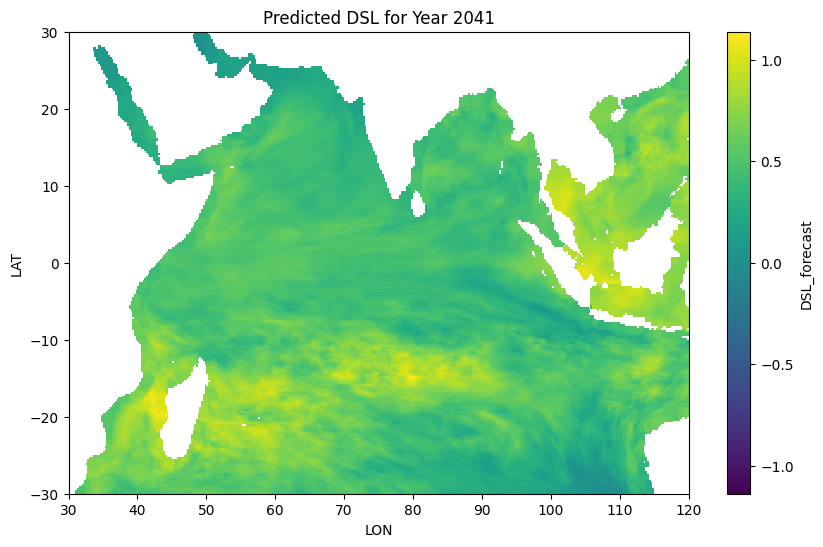

In [ ]:
year_index = 10 # for 2041
plt.figure(figsize=(10, 6))
dsl_pred2.isel(TIME=year_index).plot(cmap='viridis')
plt.title(f"Predicted DSL for Year {int(dsl_pred2.TIME[year_index].values)}")
plt.show()


In [ ]:
print(dsl_pred2.isel(TIME=year_index).min().item())
print(dsl_pred2.isel(TIME=year_index).max().item())
print(dsl_pred2.isel(TIME=year_index).mean().item())


-0.07479577511548996
1.1374915838241577
0.5189525485038757


In [ ]:
dsl_pred2.TIME[year_index]

<xarray.DataArray 'TIME' ()> Size: 4B
array(2041, dtype=int32)
Coordinates:
    TIME     int32 4B 2041

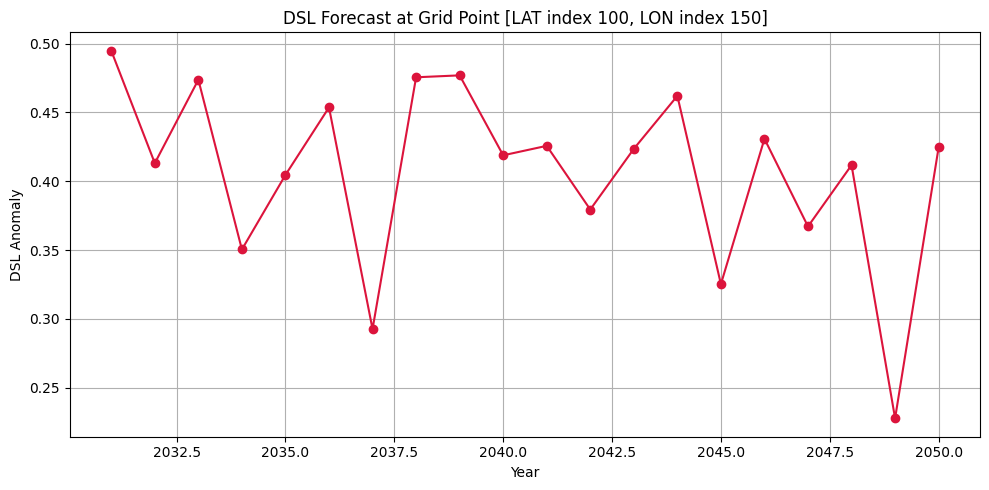

In [ ]:
import matplotlib.pyplot as plt

lat_index = 100
lon_index = 150

# Extract time series for the selected grid point
dsl_series = dsl_pred2[:, lat_index, lon_index]  # shape: (20,)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(dsl_pred2.TIME, dsl_series, marker='o', color='crimson')
plt.title(f"DSL Forecast at Grid Point [LAT index {lat_index}, LON index {lon_index}]")
plt.xlabel("Year")
plt.ylabel("DSL Anomaly")
plt.grid(True)
plt.tight_layout()
plt.show()


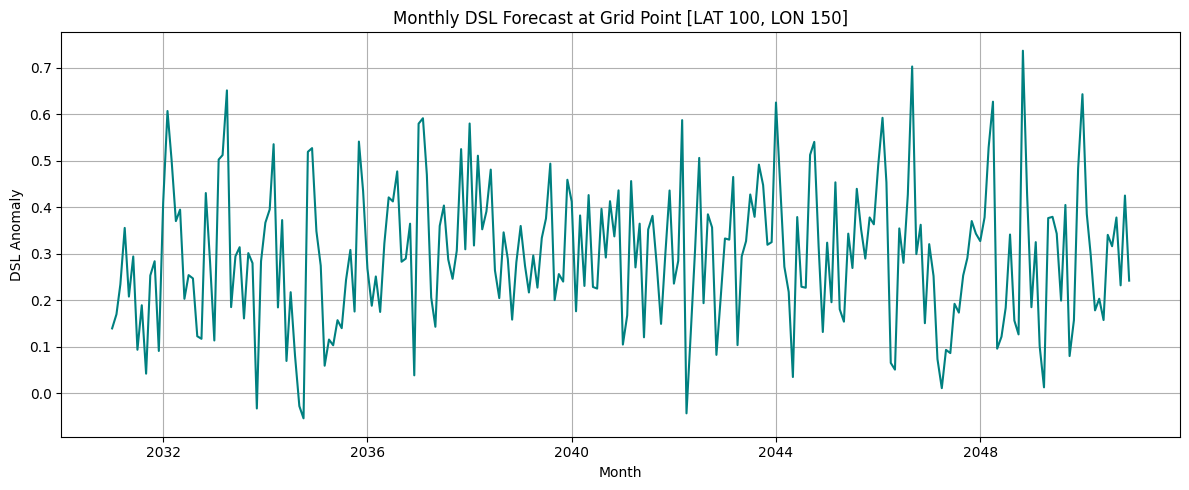

In [ ]:
lat_index = 100
lon_index = 150
grid_index = lat_index * n_lon + lon_index  # flattening (row-major)

# Extract monthly series: shape (240,) — 240 months from 2025 to 2044
monthly_series = y_pred[grid_index, :240]

# Create monthly time axis
months = np.arange('2031-01', '2051-01', dtype='datetime64[M]')  # 240 months

# Plot
plt.figure(figsize=(12, 5))
plt.plot(months, monthly_series, color='teal')
plt.title(f"Monthly DSL Forecast at Grid Point [LAT {lat_index}, LON {lon_index}]")
plt.xlabel("Month")
plt.ylabel("DSL Anomaly")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate indices for input window
# 2036 corresponds to index 996 (1860 + 96 years * 12 months)
# So input should be from 732 to 995 (i.e., 264 months ending just before 2036)

x_input = dsl[732:996, :, :]  # shape: (264, 240, 360)
x_input = np.transpose(x_input, (1, 2, 0)).reshape(-1, 264)
x_tensor = torch.from_numpy(x_input).float().unsqueeze(1).to(device)

# Predict in batches to avoid OOM
batch_size = 512
y_pred = []

model.eval()
with torch.no_grad():
    for i in range(0, n_grid, batch_size):
        batch = x_tensor[i:i + batch_size]
        pred_batch = model(batch).squeeze(1).cpu().numpy()
        y_pred.append(pred_batch)

y_pred = np.concatenate(y_pred, axis=0)

# Keep first 240 months (20 years), reshape to annual mean
y_pred_sliced = y_pred[:, :240]  # (N, 240)
y_pred_annual = y_pred_sliced.reshape(n_grid, 20, 12).mean(axis=2)  # (N, 20)
forecast_reshaped = y_pred_annual.reshape(n_lat, n_lon, 20).transpose(2, 0, 1)

# Create annual time coordinate for 2036–2055
forecast_years = np.arange(2036, 2056)

# Save to dataset
forecast_ds3 = xr.DataArray(
    forecast_reshaped,
    dims=['TIME', 'LAT', 'LON'],
    coords={
        'TIME': forecast_years,
        'LAT': ssp_585['LAT'],
        'LON': ssp_585['LON']
    },
    name='DSL_forecast'
).to_dataset(name='DSL_forecast')


# forecast_ds3.to_netcdf("/content/drive/MyDrive/prerna_data/ssp585_predictions/ssp585_forecast_2036_2055.nc")
# print(" Forecast for 2036–2055 saved.")


 Forecast for 2036–2055 saved.


In [ ]:
forecast_ds3=xr.open_dataset("/content/drive/MyDrive/prerna_data/ssp585_predictions/ssp585_forecast_2036_2055.nc")

In [ ]:
dsl_pred3=forecast_ds3['DSL_forecast']

In [ ]:
dsl_pred3

<xarray.DataArray 'DSL_forecast' (TIME: 20, LAT: 240, LON: 360)> Size: 7MB
[1728000 values with dtype=float32]
Coordinates:
  * LON      (LON) float64 3kB 30.12 30.38 30.62 30.88 ... 119.4 119.6 119.9
  * LAT      (LAT) float64 2kB -29.88 -29.62 -29.38 -29.12 ... 29.38 29.62 29.88
  * TIME     (TIME) int32 80B 2036 2037 2038 2039 2040 ... 2052 2053 2054 2055

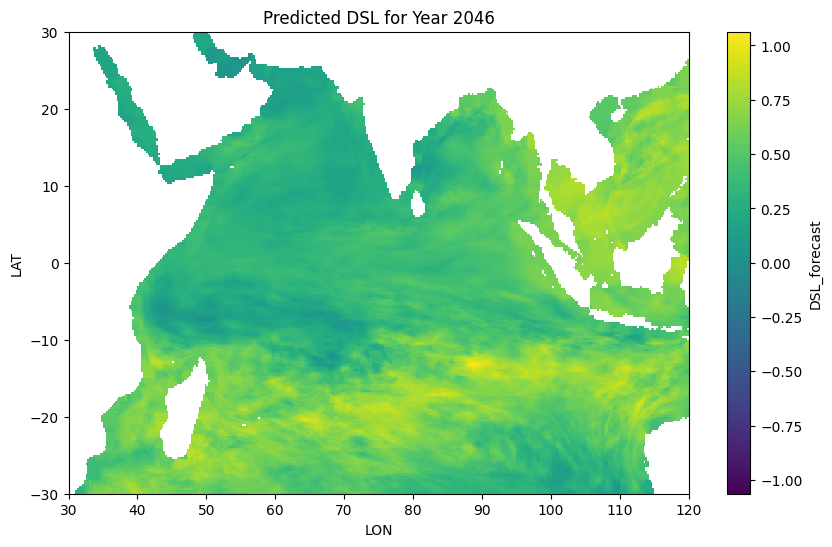

In [ ]:
year_index = 10
plt.figure(figsize=(10, 6))
dsl_pred3.isel(TIME=year_index).plot(cmap='viridis')
plt.title(f"Predicted DSL for Year {int(dsl_pred3.TIME[year_index].values)}")
plt.show()


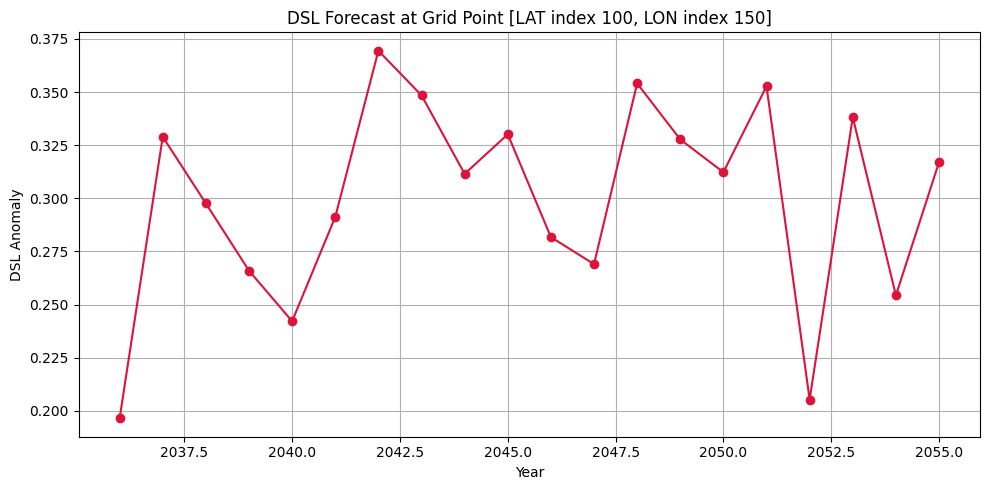

In [ ]:
lat_index = 100
lon_index = 150

# Extract time series for the selected grid point
dsl_series = dsl_pred3[:, lat_index, lon_index]  # shape: (20,)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(dsl_pred3.TIME, dsl_series, marker='o', color='crimson')
plt.title(f"DSL Forecast at Grid Point [LAT index {lat_index}, LON index {lon_index}]")
plt.xlabel("Year")
plt.ylabel("DSL Anomaly")
plt.grid(True)
plt.tight_layout()
plt.show()


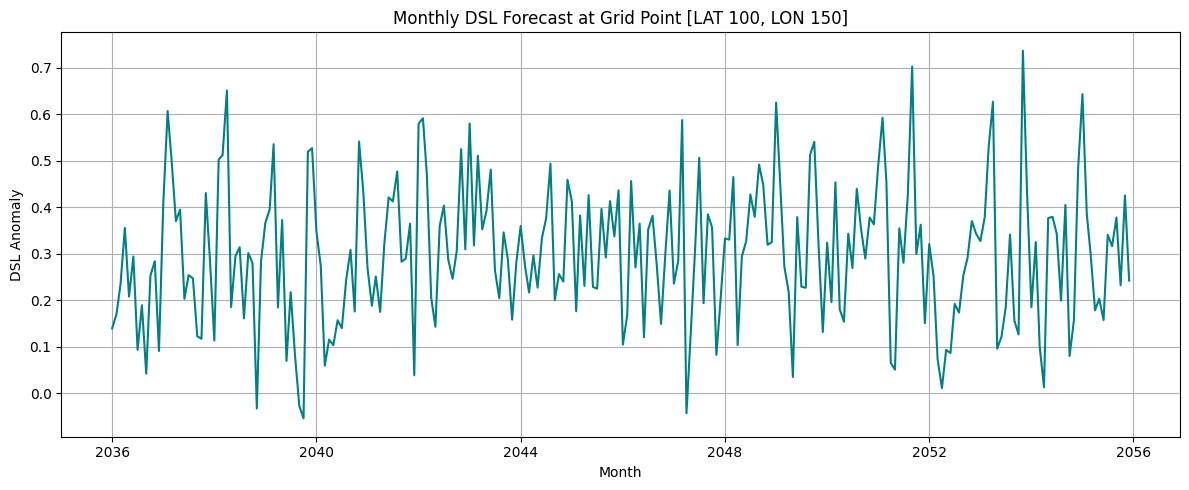

In [ ]:
lat_index = 100
lon_index = 150
grid_index = lat_index * n_lon + lon_index  # flattening (row-major)

# Extract monthly series: shape (240,) — 240 months from 2025 to 2044
monthly_series = y_pred[grid_index, :240]

# Create monthly time axis
months = np.arange('2036-01', '2056-01', dtype='datetime64[M]')  # 240 months

# Plot
plt.figure(figsize=(12, 5))
plt.plot(months, monthly_series, color='teal')
plt.title(f"Monthly DSL Forecast at Grid Point [LAT {lat_index}, LON {lon_index}]")
plt.xlabel("Month")
plt.ylabel("DSL Anomaly")
plt.grid(True)
plt.tight_layout()
plt.show()
